# Analyze Data

In [1]:
# imports
import os
import pickle
import json
import random
import csv

import cv2
import numpy as np
import os
import csv
import glob

import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
data_dir = 'data2/'
logs = glob.glob(data_dir+'*.csv')
print(logs)

['data2/driving_log_normal_062017.csv', 'data2/driving_log_org_march112017.csv', 'data2/driving_log_recovery_march112017.csv', 'data2/driving_log_udacity.csv']


In [3]:
# load training data
frames = []
for f in logs:
    df_tmp = pd.read_csv(f, header=0)
    df_tmp.columns = ["center_image", "left_image", "right_image", "steering_angle", "throttle", "break", "speed"]
    print('log: ', f)
    print('len: ', len(df_tmp))
    frames.append(df_tmp)

# print(frames[3].tail())
df = pd.concat(frames,ignore_index=True)
print('total len: ', len(df))
# df
# # df.head()
# df.index
# df.columns
# df.values
# df.describe()
# df.dtypes
df.tail(3)


log:  data2/driving_log_normal_062017.csv
len:  596
log:  data2/driving_log_org_march112017.csv
len:  5924
log:  data2/driving_log_recovery_march112017.csv
len:  2190
log:  data2/driving_log_udacity.csv
len:  8035
total len:  16745


center_image  \
16742  IMG/center_2016_12_01_13_46_38_846.jpg   
16743  IMG/center_2016_12_01_13_46_38_922.jpg   
16744  IMG/center_2016_12_01_13_46_38_947.jpg   

                                  left_image  \
16742   IMG/left_2016_12_01_13_46_38_846.jpg   
16743   IMG/left_2016_12_01_13_46_38_922.jpg   
16744   IMG/left_2016_12_01_13_46_38_947.jpg   

                                  right_image  steering_angle  throttle  \
16742   IMG/right_2016_12_01_13_46_38_846.jpg             0.0       0.0   
16743   IMG/right_2016_12_01_13_46_38_922.jpg             0.0       0.0   
16744   IMG/right_2016_12_01_13_46_38_947.jpg             0.0       0.0   

       break     speed  
16742    0.0  1.388364  
16743    0.0  1.377208  
16744    0.0  1.374433

4916


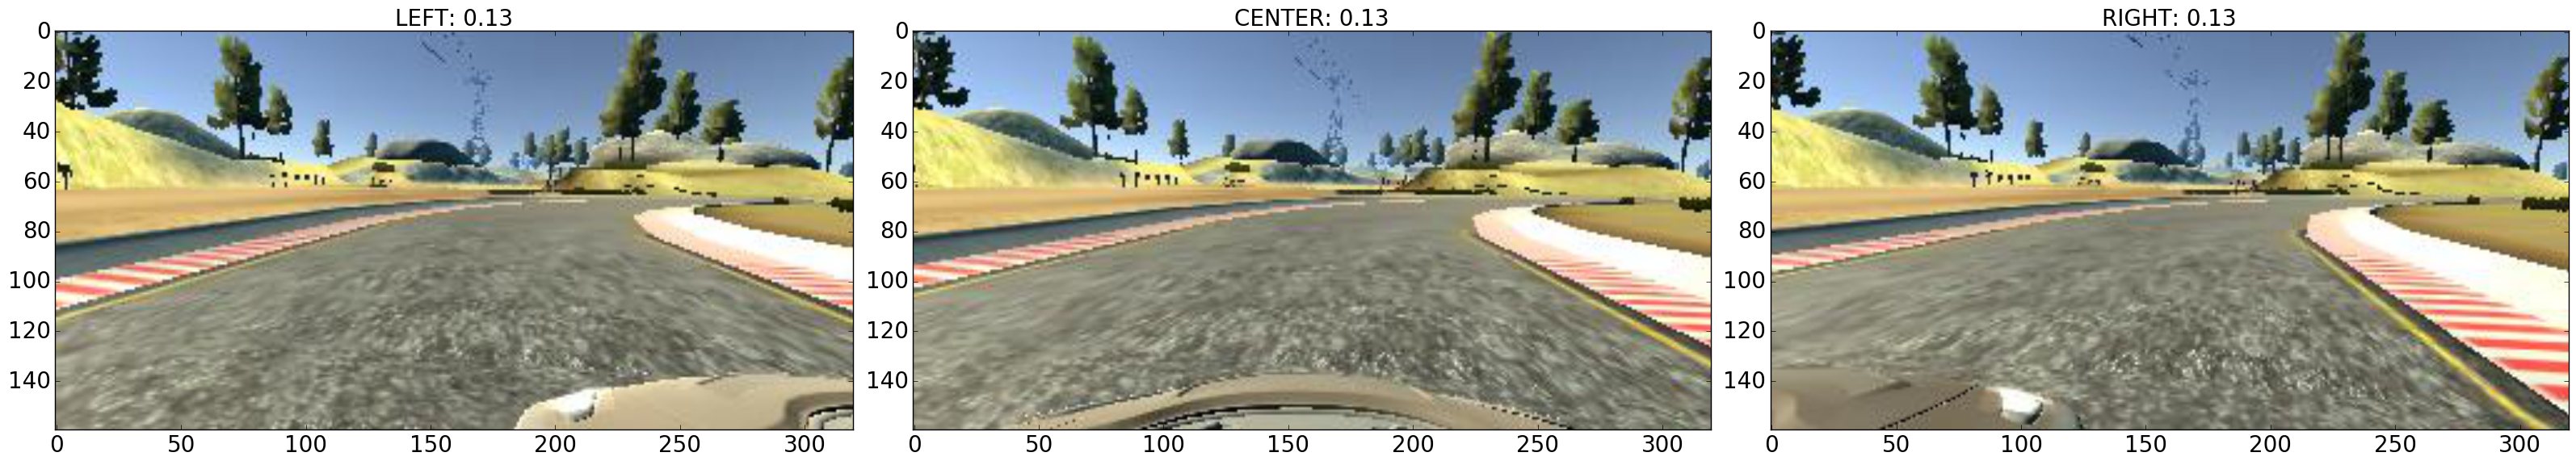

In [4]:
####################################################################
## Visualize left, center and right angle camera at the same moment
####################################################################
chk_idx =int(np.random.uniform(1, len(df)))
print(chk_idx)
img_left = cv2.imread(data_dir+df["left_image"][chk_idx].strip())
img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
img_center = cv2.imread(data_dir+df["center_image"][chk_idx].strip())
img_center = cv2.cvtColor(img_center, cv2.COLOR_BGR2RGB)
img_right = cv2.imread(data_dir+df["right_image"][chk_idx].strip())
img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
angle = df["steering_angle"][chk_idx]
plt.rcParams["figure.figsize"] = [32, 24]
plt.tick_params(axis='x', labelsize=25)

plt.subplot(1, 3, 1)
plt.imshow(img_left)
plt.title("LEFT: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.subplot(1, 3, 2)
plt.imshow(img_center)
plt.title("CENTER: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.subplot(1, 3, 3)
plt.imshow(img_right)
plt.title("RIGHT: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.tight_layout()
plt.show()

0 IMG/center_2017_05_29_20_04_53_639.jpg
1 IMG/center_2017_05_29_20_04_53_712.jpg
2 IMG/center_2017_05_29_20_04_53_783.jpg
img_height: 160
img_width: 320
img_channel: 3
min angle:  -0.9426954
max angle:  1.0


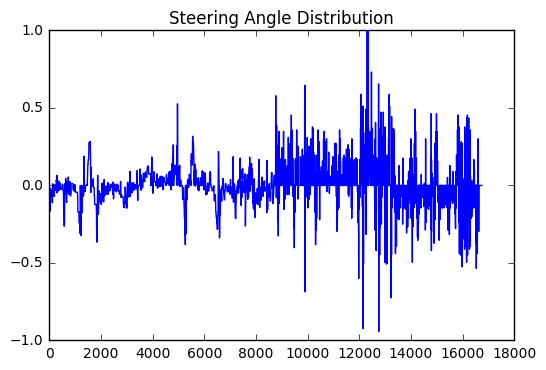

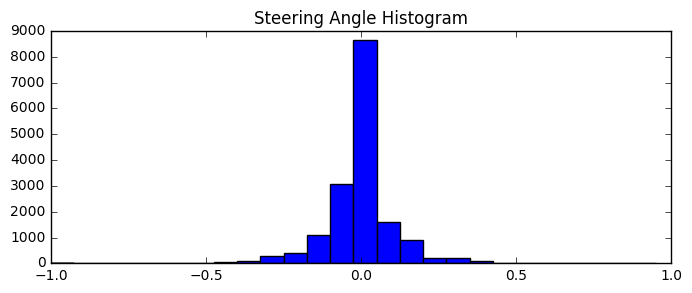

NameError: name 'hist' is not defined

In [5]:
## data discovery
for i in range(3):
    print (i, '{:}'.format(df["center_image"][i]))

# This is a 160 pixel x 320 pixel x 3 channels
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL = img_center.shape
print("img_height:", IMG_HEIGHT)
print("img_width:", IMG_WIDTH)
print("img_channel:", IMG_CHANNEL)

min_angle = np.min(df["steering_angle"])
max_angle = np.max(df["steering_angle"])
print('min angle: ', min_angle)
print('max angle: ', max_angle)

# Time Series plot of steering angles
plt.rcParams["figure.figsize"] = [32, 24]
plt.figure(figsize=(6, 4))
plt.title("Steering Angle Distribution")
ts = df["steering_angle"]
plt.plot(ts)

plt.figure(figsize=(8,3))
plt.hist(ts.astype('float'), bins=np.arange(-1.0, 1.0, 0.075))
plt.title("Steering Angle Histogram")
plt.show()

# Create Steering Angle Bin Counts  
steer_bin = []
for i in range(len(hist)):
    steer_bin.append([bins[i], bins[i+1], hist[i]])
    
# Examine Steering Angle Bin Counts
steer_bin

Most of the time the car was going straight as shown by the histogram.  I'm going to over-sample larger steering angles and down-sample near 0 steering angle data.

In [ ]:
# Take a look at https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

df_right = []
df_left = []
df_center = []
for i in range(len(df)):
    center_img = df["center_image"][i]
    left_img = df["left_image"][i]
    right_img = df["right_image"][i]
    angle = df["steering_angle"][i]
    if (angle > 0.1):
        df_right.append([center_img, left_img, right_img, angle])
        
        # I'm adding a small deviation of the angle 
        # This is to create more right turning samples for the same image
        for i in range(5):
            new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
            df_right.append([center_img, left_img, right_img, new_angle])
            
    elif (angle < -0.1):
        df_left.append([center_img, left_img, right_img, angle])
        
        # I'm adding a small deviation of the angle
        # This is to create more left turning samples for the same image
        for i in range(5):
            new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
            df_left.append([center_img, left_img, right_img, new_angle])
            
    else:
        if (angle != 0.0):
        # Include all near 0 angle data
            df_center.append([center_img, left_img, right_img, angle])
            
print(len(df_center), len(df_left), len(df_right))

In [ ]:
# Shuffle the data so they're no longer sequential in the order that the data was collected
random.shuffle(df_center)
random.shuffle(df_left)
random.shuffle(df_right)
df_center = pd.DataFrame(df_center, columns=["center_image", "left_image", "right_image", "steering_angle"])
df_left = pd.DataFrame(df_left, columns=["center_image", "left_image", "right_image", "steering_angle"])
df_right = pd.DataFrame(df_right, columns=["center_image", "left_image", "right_image", "steering_angle"])

In [ ]:
# Make the train and valid list 
data_list = [df_center, df_left, df_right]
data_list_df = pd.concat(data_list, ignore_index=True)
len(data_list_df)

# histogram after data augmentation
ts = data_list_df["steering_angle"]
plt.figure(figsize=(8,3))
plt.hist(ts.astype('float'), bins=np.arange(-1.0, 1.0, 0.075))
plt.title("Steering Angle Histogram")
plt.show()

In [ ]:
# y_data is not used as it is already contained in X_data's column
# but I made it to conform to the train_test_split function format
X_data = data_list_df[["center_image","left_image","right_image","steering_angle"]]
y_data = data_list_df["steering_angle"]

X_data = pd.DataFrame(X_data, columns=["center_image", "left_image", "right_image", "steering_angle"])
y_data = pd.DataFrame(y_data, columns=["steering_angle"])
X_train_data, X_valid_data, y_train_data, y_valid_data = train_test_split(X_data, y_data, test_size=0.2)

# Resets the row index
X_train_data = X_train_data.reset_index(drop=True)
X_valid_data = X_valid_data.reset_index(drop=True)
# X_train_data[0:5]
print(len(X_train_data), len(X_valid_data))

(160, 320, 3)
(66, 200, 3)


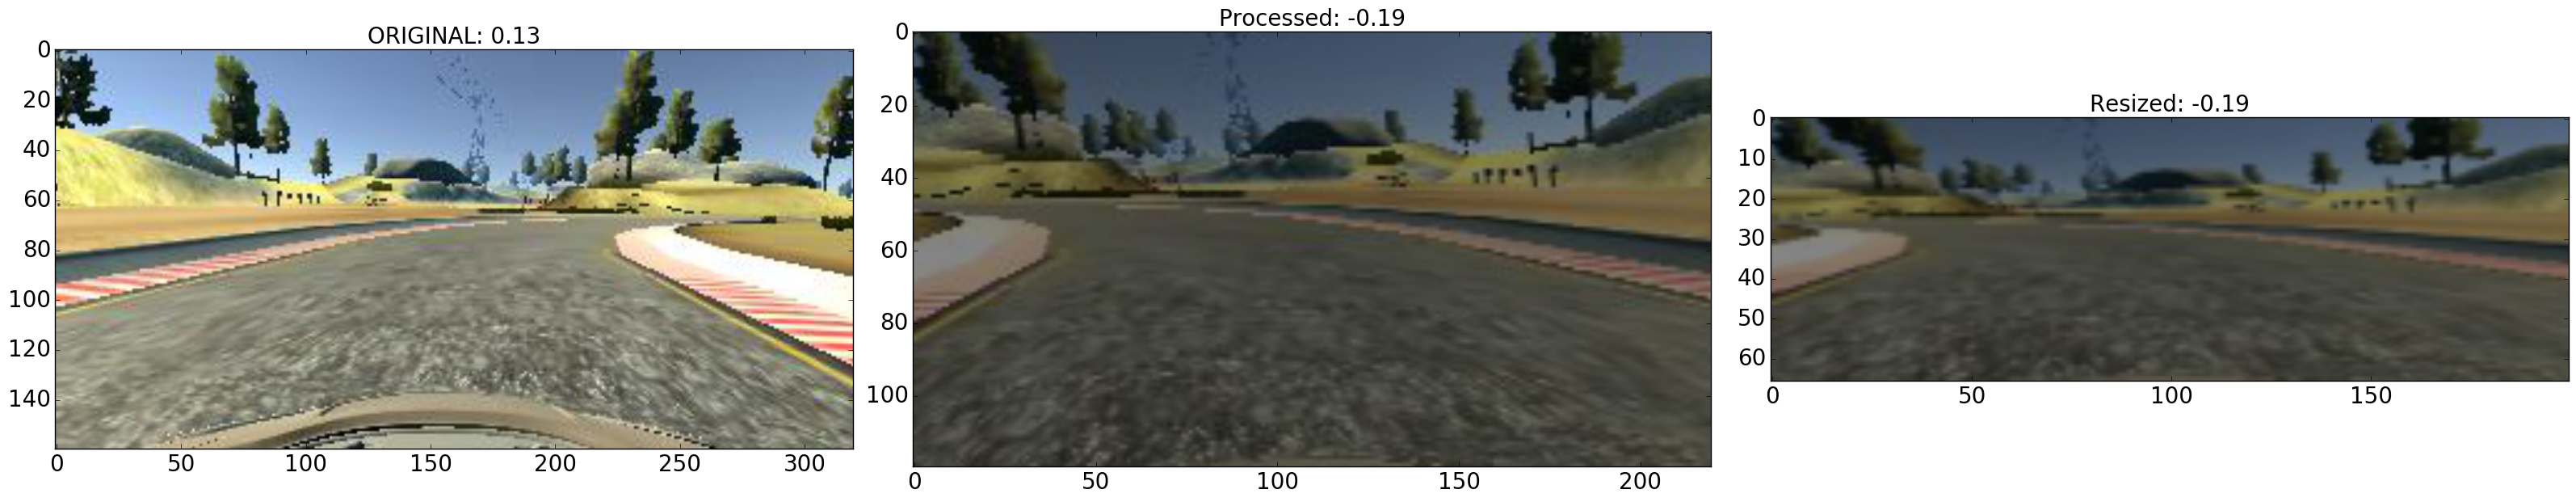

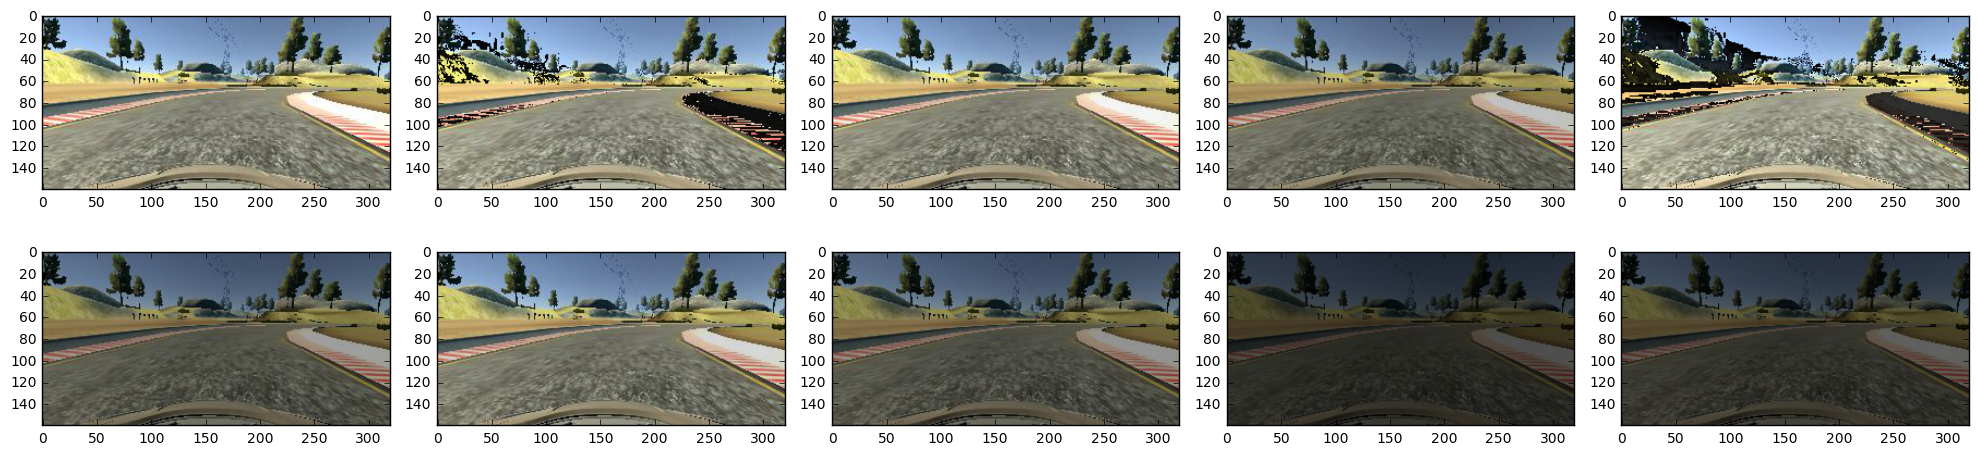

In [8]:
from img_preprocess import img_preprocess, augment_brightness

row, col, ch = img_center.shape
img_center = img_center.reshape(row, col, ch)
print(img_center.shape)
img_center_processed, angle_processed = img_preprocess(img_center, angle)
img_center_resized = cv2.resize(img_center_processed, (200,66), interpolation=cv2.INTER_AREA)
print(img_center_resized.shape)


plt.rcParams["figure.figsize"] = [32, 24]
plt.tick_params(axis='x', labelsize=25)
plt.subplot(1, 3, 1)
plt.imshow(img_center)
plt.title("ORIGINAL: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.subplot(1, 3, 2)
plt.imshow(img_center_processed)
plt.title("Processed: " + str(np.round(angle_processed, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.subplot(1, 3, 3)
plt.imshow(img_center_resized)
plt.title("Resized: " + str(np.round(angle_processed, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.tight_layout()
plt.show()


plt.rcParams["figure.figsize"] = [20, 5]
for i in range(0, 10):
    plt.subplot(2, 5, i+1) 
    plt.tight_layout()
    if i == 0:
        plt.imshow(img_center) 
    else:
        plt.imshow(augment_brightness(img_center))


NameError: name 'X_train_data' is not defined